In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from control import *
%matplotlib inline

In [2]:
sns.set_color_codes(palette='dark')
sns.set(style="whitegrid")

In [3]:
np.random.seed(0)

In [4]:
# number of measurements
N = 1250
t = np.arange(0,N).transpose()
sig = 1e-2 # std of noise corrupting measurements

In [6]:
# model parameters
a1 = -1.51*np.ones((N,1))
a2 = 0.55*np.ones((N,1))
b1 = 0.6*np.ones((N,1))
b2 = 0.16*np.ones((N,1))

In [7]:
# add changes in the parameters
a1[250:]  = 0.8*a1[0]
a2[500:]  = 1.2*a2[0]
b1[750:]  = 0.3*b1[0]
b2[1000:] = 2*b2[0]

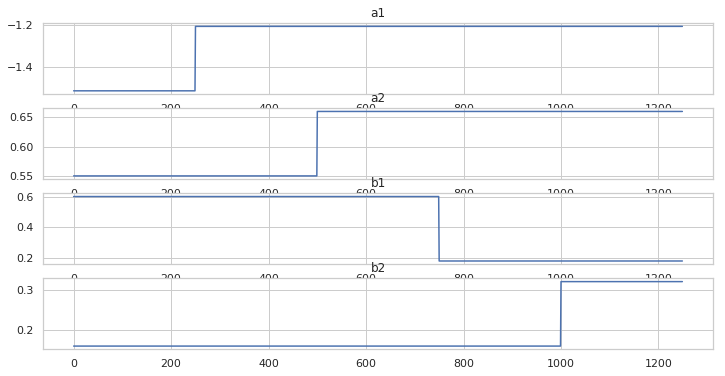

In [8]:
# plot parameters
fig,axes = plt.subplots(nrows=4, ncols=1, figsize=(12,6))

axes[0].set_title("a1")
axes[0].plot(t,a1,color='b')

axes[1].set_title("a2")
axes[1].plot(t,a2,color='b')

axes[2].set_title("b1")
axes[2].plot(t,b1,color='b')

axes[3].set_title("b2")
axes[3].plot(t,b2,color='b')

In [13]:
# init
yr = np.zeros((N,1)) # model (no noise)
u = np.zeros((N,1))

for i in range(0,N):
    if np.random.rand(1)>0.5:
        u[i] = 1
    else:
        u[i] = -1

for k in range(2,N):
    yr[k] = - a1[k]*yr[k-1] - a2[k]*yr[k-2] + b1[k]*u[k-1] + b2[k]*u[k-2]

y = yr + sig*np.random.randn(N,1) # measurements (corrupted by noise)

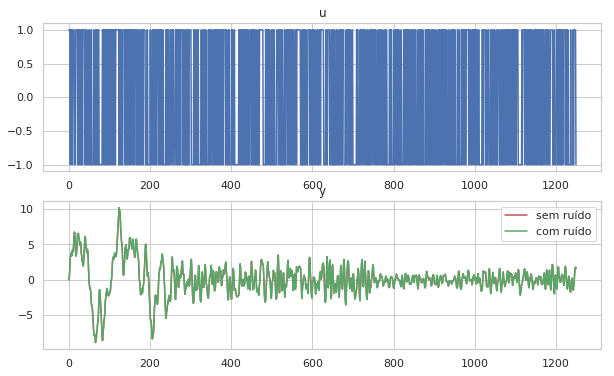

In [14]:
fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))

axes[0].set_title("u")
axes[0].plot(t,u,color='b')

axes[1].set_title("y")
axes[1].plot(t,yr,color='r',label='sem ruído')
axes[1].plot(t,y,color='g',label='com ruído')
axes[1].legend(loc=1)

In [63]:
# perform RLS

# initialize parameters
P = 1e4*np.identity(4) # P initial condition
th = np.array([0, 0, 0, 0]) # theta initial condition
lambd = 0.98 # forgetting factor
yh = np.zeros((N,1)) # prediction
e = np.zeros((N,1)) # prediction error

In [64]:
a1h = np.zeros((N,1))
a2h = np.zeros((N,1))
b1h = np.zeros((N,1))
b2h = np.zeros((N,1))

In [65]:
# strategy = 1 # RLS
# strategy = 2 # random walk
# strategy = 3 # forgetting factor
strategy = 4 # cov res

In [66]:
for k in range(3,N):
    # Step 2
    phi = np.array([-y[k-1], -y[k-2], u[k-1], u[k-2]]) # regression vector

    # Step 3
    th2 = th.reshape(phi.shape)
    
    yh[k] = np.dot(phi.transpose(), th2)
    e[k] = y[k] - yh[k]
    
    # Step 4
    if (strategy == 3): # forgetting factor
        K = np.dot(P, phi)/(lambd+np.dot(phi.transpose(),np.dot(P, phi)))
    
    else:
        K = np.dot(P, phi)/(1+np.dot(phi.transpose(),np.dot(P, phi)))

    # Step 5
    th = th + np.dot(K, e[k]) # Kalman filter (almost)
    
    # Step 6    
    if (strategy == 1): # RLS
        P = P - np.dot(K, np.dot(P, phi).transpose())
    
    elif (strategy == 2): # random walk
        P = P - np.dot(K, np.dot(P, phi).transpose())
        P = P/1000 # reduce amplitude of elements
        p = len(th) + 1
        q = np.trace(P)/p
        Q = q*np.identity(len(P))
        #print(Q)
        P = np.add(P, Q)
        #print(P)
    
    elif (strategy == 3): # forgetting factor
        P = (1/lambd)*(P - np.dot(K, np.dot(P, phi).transpose()))
    
    elif (strategy == 4): # forgetting factor
        if (t[k] == 10):
            P = 5e3*np.identity(4)
        else:
            P = (1/lambd)*(P - np.dot(K, np.dot(P, phi).transpose()))
    
    # store estimated parameters for plotting
    a1h[k] = th[0]
    a2h[k] = th[1]
    b1h[k] = th[2]
    b2h[k] = th[3]

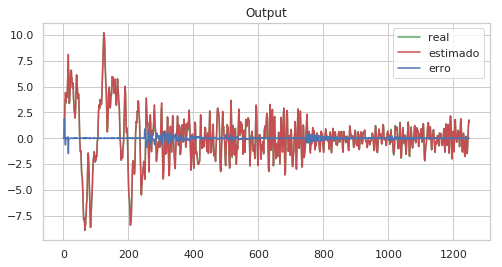

In [67]:
# plot output: real vs estimated and residual
fig,axes = plt.subplots(figsize=(8,4))

axes.set_title("Output")
axes.plot(t,yr,color='g',label="real")
axes.plot(t,yh,color='r',label="estimado")
axes.plot(t,e,color='b',label="erro")
#axes.set_ylim([0,1])
axes.legend(loc=1)

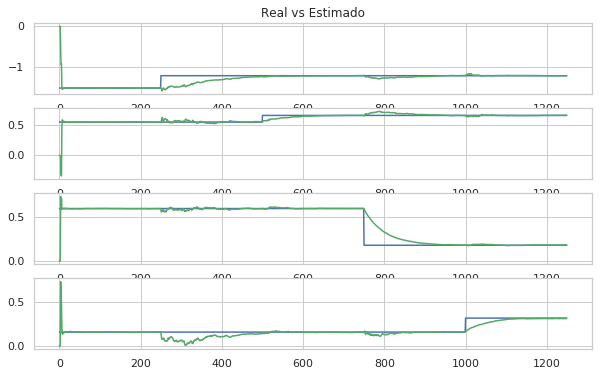

In [51]:
# plot output: real vs estimated
fig,axes = plt.subplots(nrows=4, ncols=1, figsize=(10,6))

axes[0].set_title("Real vs Estimado")
axes[0].plot(t,a1,color='b',label="real")
axes[0].plot(t,a1h,color='g',label="estimado")

axes[1].plot(t,a2,color='b',label="real")
axes[1].plot(t,a2h,color='g',label="estimado")

axes[2].plot(t,b1,color='b',label="real")
axes[2].plot(t,b1h,color='g',label="estimado")

axes[3].plot(t,b2,color='b',label="real")
axes[3].plot(t,b2h,color='g',label="estimado")